In [40]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# notebook configuration
pd.set_option("display.max_rows", 10)

file_names = ['brands','orderlines','orders','products']
path = '../project-data/raw-data/'
df_list = []

for name in file_names:
    temp_df = pd.read_csv(path + name + '.csv')
    df_list.append(temp_df)

brands, orderlines, orders, products = df_list[0].copy(), df_list[1].copy(), df_list[2].copy(), df_list[3].copy()

# General platform questions

In [41]:
# How many orders are there?
orders_qty = orders.shape[0]
print('Orders quantity: ', orders_qty)

Orders quantity:  226909


In [42]:
# How many products are there?
prod_qty = products.drop_duplicates('sku').shape[0]
print('Products quantity: ', prod_qty)

Products quantity:  10579


In [43]:
 What period of time do these orders comprise?
print(
    'Results in orders:\n',
    orders.assign(created_at = pd.to_datetime(orders.created_date)).agg({'created_at':['min','max']}), 
    '\n'
)

# does it match with the information on the orders
print(
    'Results in order lines:\n',
    orderlines.assign(date = pd.to_datetime(orderlines.date)).agg({'date':['min','max']})
)
# yes! they match

Object `comprise` not found.
Results in orders:
              created_at
min 2017-01-01 00:07:19
max 2018-03-14 13:58:36 

Results in order lines:
                    date
min 2017-01-01 00:07:19
max 2018-03-14 13:58:36


In [44]:
# How many orders are Completed?
print('Number of observations', orders.value_counts('state'), '\n')

print('Qty completed orders:', orders.value_counts('state').filter(regex = 'Completed').values[0])

Number of observations state
Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14379
Cancelled            7233
dtype: int64 

Qty completed orders: 46605


In [45]:
# How should revenue be computed?
print('Total revenues on orders:', orders.query('state == "Completed"').filter(items=['total_paid'], axis=1).sum())

Total revenues on orders: total_paid    15910079.24
dtype: float64


# Data Cleaning

In [46]:
print(str(round(products.drop_duplicates().shape[0] / products.shape[0] * 100, 2)) + '% Not duplicated rows.')

# drop all duplicates
products.drop_duplicates(inplace=True)

# check again but only with 
print(str(round(products.drop_duplicates('sku').shape[0] / products.shape[0] * 100, 2)) + '% Not duplicated rows.')

# Detect the problem
print(products.value_counts('sku').head(3))

# The price is a missing value! We can drop it 
products.query('sku == "APP1197"')
products.drop_duplicates('sku', inplace=True)

54.74% Not duplicated rows.
99.99% Not duplicated rows.
sku
APP1197    2
PAC1555    1
PAC1557    1
dtype: int64


## Cleaning prices with more than two "."

### Orders

#### Missing values

In [47]:
print('Number of missing values:')
orders.isna().sum()

Number of missing values:


order_id        0
created_date    0
total_paid      5
state           0
dtype: int64

In [48]:
# They are orders with a pending state, we can drop them
orders.loc[orders['total_paid'].isna()]

,order_id,created_date,total_paid,state
127701,427314,2017-11-20 18:54:39,NaN,Pending
132013,431655,2017-11-22 12:15:24,NaN,Pending
147316,447411,2017-11-27 10:32:37,NaN,Pending
148833,448966,2017-11-27 18:54:15,NaN,Pending
149434,449596,2017-11-27 21:52:08,NaN,Pending


In [49]:
orders.dropna(inplace=True)
orders.isna().sum()

order_id        0
created_date    0
total_paid      0
state           0
dtype: int64

#### Empty orders

In [50]:
print('Before removing empty orders', orders.shape[0])
orders.query('total_paid != 0', inplace=True)
print('After removing empty orders', orders.shape[0])

Before removing empty orders 226904
After removing empty orders 207570


### Order lines

There is a problem reading the thousands ".". We will try to solve it following different methods: 

#### Data integrity

##### Option 1: Count the number of dots by unit price, and remove the first one

In [51]:
# create a copy of orderlines
ol_temp = orderlines.copy()

# count the unit prices that contains more than 1 dot: 
ol_temp_errors = ol_temp.loc[ol_temp['unit_price'].str.count(r'\.') > 1]

print(
    str(round(ol_temp_errors.shape[0] /
        ol_temp['unit_price'].shape[0] * 100, 2)) + 
    '% of rows with unit_price with two "."'
)
ol_temp_errors.head()

12.3% of rows with unit_price with two "."


,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119115,299544,0,1,APP1582,1.137.99,2017-01-01 01:17:21
11,1119126,299549,0,1,PAC0929,2.565.99,2017-01-01 02:07:42
15,1119131,299553,0,1,APP1854,3.278.99,2017-01-01 02:14:47
43,1119195,299582,0,1,PAC0961,2.616.99,2017-01-01 08:54:00
59,1119214,299596,0,1,PAC1599,2.873.99,2017-01-01 09:53:11


In [52]:
# remove the first dot of the selected column 'unit price'
good_prices = ol_temp_errors['unit_price'].str.replace(".", "", 1, regex=False)

# replace the unit prices with problems on the thousands dots
ol_temp.loc[ol_temp['unit_price'].str.count("\.") > 1, 'unit_price'] = good_prices

# tranform it to numeric
ol_temp.loc[:,'unit_price'] = pd.to_numeric(ol_temp.loc[:,'unit_price'])

# variable we will use to check the results with other options
option_1_sum = ol_temp['unit_price'].sum()
option_1_sum

120490458.80999997

##### Option 2: extract the decimals, and erase the dots from the integers

In [53]:
# create a copy of orderlines
ol_temp = orderlines.copy()

# extract all the numbers before the last dot (example: 987.99 --> 987)
ol_temp['integers'] = ol_temp['unit_price'].str[:-3]

# extract all the decimals in a number and the dot (example: 987.99 --> .99)
ol_temp['decimals'] = ol_temp['unit_price'].str[-3:]
ol_temp.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,integers,decimals
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,18,.99
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,399,.00
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,474,.05
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,68,.39
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,23,.74


In [54]:
# remove all the dots in the integers and join them again with the decimals
ol_temp['unit_price'] = ol_temp['integers'].str.replace('.','', regex=False) + ol_temp['decimals']

# transform to numeric
ol_temp['unit_price'] = pd.to_numeric(ol_temp['unit_price'])

# error check
option_2_sum = ol_temp['unit_price'].sum()
print('Are both option the same?', option_1_sum == option_2_sum)
option_2_sum

Are both option the same? True


120490458.80999997

##### Applying the changes to order lines

In [55]:
orderlines = ol_temp.drop(columns=['integers','decimals'])

### Products

#### Duplicated rows

In [56]:
print(str(round(products.drop_duplicates().shape[0] / products.shape[0] * 100, 2)) + '% Not duplicated rows.')

# drop all duplicates
products.drop_duplicates(inplace=True)

# check again but only with 
print(str(round(products.drop_duplicates('sku').shape[0] / products.shape[0] * 100, 2)) + '% Not duplicated rows.')

# Detect the problem
print(products.value_counts('sku').head(3))

# The price is a missing value! We can drop it 
products.query('sku == "APP1197"')
products.drop_duplicates('sku', inplace=True)

100.0% Not duplicated rows.
100.0% Not duplicated rows.
sku
8MO0001-A    1
PAC1556      1
PAC1558      1
dtype: int64


#### Data integrity & missing values

##### Error location

In [57]:
# look for all the prices which have 3 digits after its dots
regexp = '\.\d{3}'
prod_price_error = products.loc[products['price'].str.count(regexp) != 0]

print(
    'Number of products with two ".":',
    str(prod_price_error.shape[0]) + 
    '. They are', str(round(prod_price_error.shape[0] / products.shape[0] * 100, 1)) + 
    "% of the products."
)
# check the percentage in the orders_lines
prod_price_error.head()

Number of products with two ".": 587. They are 5.5% of the products.


,sku,name,desc,price,promo_price,in_stock,type
34,TWS0019,Twelve South MagicWand support Apple Magic Tra...,MagicWand for wireless keyboard and Magic Trac...,NaN,299.899,0,8696
362,REP0043,Speaker lower repair iPhone 4,Repair service including parts and labor for i...,499.004,499.004,0,"1,44E+11"
480,PIE0011,Internal Battery for iPhone 3G,Replacement AC Adapter for Apple iPhone 3G.,98.978,98.978,0,21485407
515,SEN0061,Sennheiser EZX 80 Handsfree iPhone iPad and iP...,IPhone bluetooth headset with microphone iPad ...,649.891,649.891,0,5384
518,SEV0026,Service installation RAM + HDD + SSD MacBook /...,RAM + HDD installation + SSD in your MacBook /...,599.918,599.918,0,20642062


In [58]:
# looking at the % of order lines that contains this products
print(
    str(round((orderlines.loc[orderlines['sku'].isin(prod_price_error['sku'].tolist())].shape[0] / orderlines.shape[0])*100, 2)) +
    '% of order lines with products with errors.'
)

print(
    str(round(orderlines.loc[orderlines['sku'].isin(prod_price_error['sku'].tolist())]['unit_price'].sum() / orderlines['unit_price'].sum() * 100, 2)) + 
    '% of the total order lines revenue'
)

2.49% of order lines with products with errors.
2.54% of the total order lines revenue


##### Solution 1: drop all the products with problem in prices

##### Solution 2: fill the problems with orderlines information

In [59]:
# To solve that problem, I am going to substitute all the weird prices with a missing value
# import nan function from numpy to substitute the values with a missing value
from numpy import nan
products.loc[products['price'].str.count(regexp) > 1, 'price'] = nan

# transform to numeric the price column on products
products['price'] = pd.to_numeric(products['price'])
products.info()
# show the missing values on the dataset
print('Missing values on products: ')
products.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10579 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sku          10579 non-null  object 
 1   name         10579 non-null  object 
 2   desc         10572 non-null  object 
 3   price        10157 non-null  float64
 4   promo_price  10579 non-null  object 
 5   in_stock     10579 non-null  int64  
 6   type         10529 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 661.2+ KB
Missing values on products: 


sku              0
name             0
desc             7
price          422
promo_price      0
in_stock         0
type            50
dtype: int64

In [60]:
# Can I fill this missing data with orderlines information?
# Yes, using the maximum price in the orderlines
prod_na_price = (
products
    # locate only the rows that has a missing value in the column price
    .loc[products['price'].isna()]
    # merge with orderlines to look at the information of this products
    .merge(orderlines, how='left',on='sku')
    # find out the maximum value in unit price for each sku
    .groupby(['sku'])
    .agg({'unit_price':'max'})
    # reset index to keep on performing pandas operations
    .reset_index()
    # rename the columns to make sense of the values on it
    .rename(columns = {'unit_price':'max_price'})
    # round the price to two digits to help us understand them 
    .assign(max_price = lambda x: round(x['max_price'], 2))
    # drop all the products missing in orderlines
    .dropna()
)
prod_na_price.head()

,sku,max_price
1,APP0660-A,253.11
6,APP0869,539.00
7,APP0870,539.00
8,APP0871,539.00
9,APP0879,659.00


In [61]:
# it seems there is a relation between promo price and maximum price,
# so I am going to replace the wrong prices with the maximum price in orderlines
(
products
    # locate all the rows with missing values in the column price
    .loc[products['price'].isna()]
    # join the information with the table we created before, that contains the 
    # maximum values for each product with a wrong price in products table
    .merge(prod_na_price, how='left',on='sku')
    # drop all the products that we are not able to find on the ordelines table
    .dropna(subset=['max_price'])
    # drop columns we are not interested to see
    .drop(['desc','in_stock','type'], axis=1)
    .head()
)

,sku,name,price,promo_price,max_price
0,TWS0019,Twelve South MagicWand support Apple Magic Tra...,NaN,299.899,29.99
1,CRU0015-2,Crucial memory Mac 16GB (2x8GB) SO-DIMM DDR3 1...,NaN,1.629.894,177.99
6,REP0156,iPhone 5 GSM antenna repair,NaN,699.899,68.99
7,REP0185,Home button repair iPad mini,NaN,699.899,69.99
8,REP0188,Full Screen Repair iPad Mini 2,NaN,2.099.895,209.99


In [62]:
# time to replace the missing values with the maximum price from order lines
# get the maximum price from the table prod_na_price
merged_prod = products.merge(prod_na_price, how='left', on='sku')

# fill the missing values in price with the new column 'max_price'
merged_prod['price'] = merged_prod['price'].fillna(merged_prod['max_price'])

# drop the products that do not have any maximum value (because they do not appear on orderlines)
merged_prod.dropna(subset = ['price'], inplace=True)

# create a column to remember which are the modified products price
merged_prod['inferred_price'] = merged_prod['sku'].isin(prod_na_price['sku'])
merged_prod.head()

,sku,name,desc,price,promo_price,in_stock,type,max_price,inferred_price
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,499.899,1,8696,NaN,False
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,589.996,0,13855401,NaN,False
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,569.898,0,1387,NaN,False
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,229.997,0,1230,NaN,False
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,31.99,1,1364,NaN,False


##### Apply the changes into the products table

In [63]:
products = merged_prod.drop(columns=['promo_price','in_stock','type','max_price'])
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10386 entries, 0 to 10578
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sku             10386 non-null  object 
 1   name            10386 non-null  object 
 2   desc            10379 non-null  object 
 3   price           10386 non-null  float64
 4   inferred_price  10386 non-null  bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 415.8+ KB


In [64]:
products.isna().sum()

sku               0
name              0
desc              7
price             0
inferred_price    0
dtype: int64

# Data Quality

## Check if the same order id appear in orderlines and orders

In [65]:
print('Orders id from orderlines in orders: ')
orders['order_id'].isin(orderlines['id_order']).value_counts()

Orders id from orderlines in orders: 


True     204607
False      2963
Name: order_id, dtype: int64

In [66]:
print('Orders id from orders in orderlines: ')
orderlines['id_order'].isin(orders['order_id']).value_counts()

Orders id from orders in orderlines: 


True     293556
False       427
Name: id_order, dtype: int64

How to detect which orders appear on both tables? (ordes and orderlines)
An option would be to use `.merge()` and `.query()`. You can achieve the same result with `.isin()` method.

In [67]:
order_ids = pd.merge(
    # select the columns from the two tables we want to merge
    orders['order_id'], orderlines['id_order'], 
    # select only the rows that the values appear in both tables
    how='inner', 
    # define the ids on each table
    left_on='order_id', right_on='id_order'
)
order_ids.head()

,order_id,id_order
0,241319,241319
1,241423,241423
2,242832,242832
3,243330,243330
4,243784,243784


In [68]:
# select any of the columns (both contains the same information) and transform
# it into a list
order_ids = order_ids['order_id'].to_list()

# filter the rows on orders and orderlines
orders.query('order_id in @order_ids', inplace=True)
orderlines.query('id_order in @order_ids', inplace=True)

Time to see if now we have tables (orders and orderlines) with the same order ids: 

In [69]:
print('Orders id from orderlines in orders: ')
orders['order_id'].isin(orderlines['id_order']).value_counts()

Orders id from orderlines in orders: 


True    204607
Name: order_id, dtype: int64

In [70]:
print('Orders id from orders in orderlines: ')
orderlines['id_order'].isin(orders['order_id']).value_counts()

Orders id from orders in orderlines: 


True    293556
Name: id_order, dtype: int64

## Check if the dates between ordes and orderlines matches

In [71]:
print('Min. and max. date in orders:')
orders.agg({'created_date':['min','max']})

Min. and max. date in orders:


,created_date
min,2017-01-01 00:07:19
max,2018-03-14 13:58:36


In [72]:
print('Min. and max. date in orderlines:')
orderlines.agg({'date':['min','max']})

Min. and max. date in orderlines:


,date
min,2017-01-01 00:07:19
max,2018-03-14 13:58:36


Yes, they are the same.

## Select only the completed orders in orders and orderlines

In [73]:
print('Orders rows with all the states:', orders.shape[0])
orders.query('state == "Completed"', inplace=True)
print('Orders rows with only the completed state:', orders.shape[0])

Orders rows with all the states: 204607
Orders rows with only the completed state: 46558


In [74]:
# filter the completed ordes in orderlines
print('Orderlines rows with all the states:', orderlines.shape[0])

# create a list of order id to call it later in the .query function
order_id_compl = orders['order_id'].to_list()
orderlines.query('id_order in @order_id_compl', inplace=True)

print('Orderlines rows with the completed states:', orderlines.shape[0])

Orderlines rows with all the states: 293556
Orderlines rows with the completed states: 62101


## Check all the products in orderlines are in products

In [75]:
# filter the completed ordes in orderlines
print('Orderlines rows without removing any products:', orderlines.shape[0])

# create a list of order id to call it later in the .query function
products_sku = products['sku'].to_list()
orderlines.query('sku in @products_sku', inplace=True)

print('Orderlines rows without removing any products:', orderlines.shape[0])

Orderlines rows without removing any products: 62101
Orderlines rows without removing any products: 61740


# Data exploration

## Create enriched datasets

We will group all the information in two dataframes: 

* Orders: it will include the total unit price aggregated from orderlines and the shipping cost
* Orderlines: we will merge the information from products and brands to have everything in one dataframe

### Orderlines with products and brands information

In [76]:
orderlines = (
orderlines
    # add infromation from products table
    .merge(products, how='left', on='sku')
    # create variables
    .assign(
        # extract the first three letters from sku (ex: APP001 --> APP)
        short = lambda x: x['sku'].str[0:3], 
        # boolean column to know if there is a discount or not (the price of 
        # products is different than the unit price in orderlines)
        discount = lambda x: x['unit_price'] != x['price'], 
        # calculate the % of discount: difference price (products) and 
        # unit price (orderlines) in percentage
        discount_perc = lambda x: x['price'] / x['unit_price'] - 1, 
        # calculate the total price (qty * unit price)
        total_price = lambda x: x['unit_price'] * x['product_quantity']
    )
    # add the brands information
    .merge(brands, how='left', on='short')
)

orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,name,desc,price,inferred_price,short,discount,discount_perc,total_price,long
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,False,OWC,True,0.284270,47.49,OWC
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,False,IOT,True,0.208531,18.99,iOttie
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,89.00,False,APP,True,0.232858,72.19,Apple
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,3209.00,False,PAC,True,0.250589,2565.99,Pack
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,76.99,False,CRU,True,0.264204,60.90,Crucial


### Orders with orderlines information (aggregated)

Our goal here is to check it the total price by order id in orderlines table is the same as the total paid in orders table:

In [77]:
orders = (
# we start by aggregating the information from orderlines
orderlines
    # find out the sum of the total price by each order id in orderlines
    .groupby('id_order')
    .agg({'total_price':'sum'})
    .reset_index()
    # rename the column total price for a better understanding of the values inside
    .rename(columns = {'total_price':'order_lines_paid'})
    # time to merge the aggregated table orderlines with the table orders
    .merge(orders, how='inner', left_on='id_order', right_on='order_id')
    # variable creation
    .assign(
        # boolean column to see if the orderlines total paid matches with orders 
        # total paid
        price_check = lambda x: x['order_lines_paid'] == x['total_paid'], 
        # we will assume that the difference represents the shipping cost
        shipping_cost = lambda x: x['total_paid'] - x['order_lines_paid']
    )
    .drop(columns = {'order_id'})
)

orders.head()

,id_order,order_lines_paid,created_date,total_paid,state,price_check,shipping_cost
0,241423,129.16,2017-11-06 13:10:02,136.15,Completed,False,6.99
1,242832,10.77,2017-12-31 17:40:03,15.76,Completed,False,4.99
2,243330,77.99,2017-02-16 10:59:38,84.98,Completed,False,6.99
3,245275,149.00,2017-06-28 11:35:37,149.00,Completed,True,0.00
4,245595,105.98,2017-01-21 12:52:47,112.97,Completed,False,6.99


## Revenue Analysis

In [78]:
print('Total revenue (in euros) in all the orders', 
      round(orders['total_paid'].sum()))

Total revenue (in euros) in all the orders 15861788


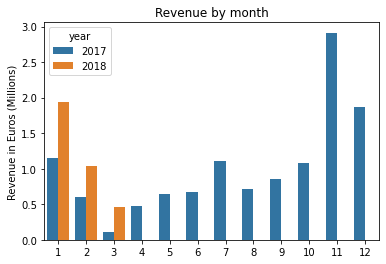

In [80]:
# see the information by month: 
plot_data = (
orders
    .assign(
        year = pd.to_datetime(orders['created_date']).dt.year, 
        month = pd.to_datetime(orders['created_date']).dt.month
    )
    .groupby(['year','month'])
    .agg({'order_lines_paid':'sum'})
    .reset_index()
    .assign(revenue = lambda x: x['order_lines_paid'] / 1e6)
)

sns.barplot(data=plot_data, x='month', y='revenue', hue='year')
plt.title("Revenue by month")
plt.ylabel('Revenue in Euros (Millions)')
plt.xlabel('')
plt.show()

## Discount Analysis

In [179]:
# detect the top products that represents 60% of the revenues, with a unit price between 0 and 7000 euros
prod_revenue = (
orderlines
    .query('0 < unit_price < 7000')
    .groupby(['sku','name','desc'])
    .agg({
        'total_price':'sum',
        'product_id':'count',
        'discount_perc':'mean',
        'unit_price':'std'
    })
    .reset_index()
    .rename(columns = {
        'product_id':'count', 
        'total_price':'revenue',
        'unit_price':'unit_price_std',
        'discount_perc':'avg_discount_perc'
    })
    .sort_values('revenue', ascending=False)
    .assign(perc = lambda x: x['revenue'] / orderlines['unit_price'].sum() * 100)
    .assign(perc_cumsum = lambda x: x['perc'].cumsum())
    .query('perc_cumsum <= 80')
)

prod_revenue.head()

,sku,name,desc,revenue,count,avg_discount_perc,unit_price_std,perc,perc_cumsum
949,APP2075,"Apple MacBook Pro 15 ""Core i7 Touch Bar 29Ghz ...",New MacBook Pro 15-inch Core i7 Touch Bar 29Gh...,215485.71,70,0.089476,65.991611,1.452847,1.452847
948,APP2074,"Apple MacBook Pro 15 ""Core i7 Touch Bar 28GHz ...",New MacBook Pro 15-inch Touch Bar to 28GHz Cor...,156383.56,61,0.095191,71.334861,1.054369,2.507215
1183,APP2490,Apple iPhone 64GB X Silver,New Apple iPhone 64GB Free Silver X,155727.70,130,0.023449,57.341093,1.049947,3.557162
2868,LGE0044,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",99% Professional Monitor sRGB color calibrator...,140272.29,209,0.059262,18.477225,0.945743,4.502905
1182,APP2489,Apple iPhone 64GB Space Gray X,New Free iPhone 64GB X,137530.55,118,0.020850,35.411603,0.927258,5.430163


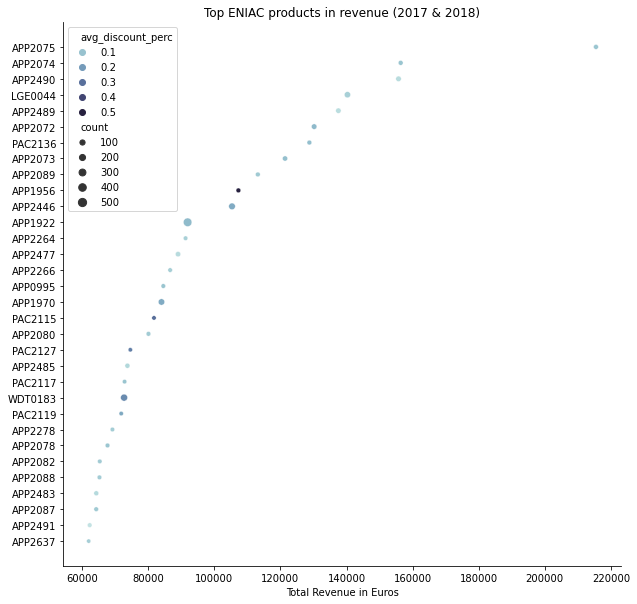

In [110]:
plot_data = prod_revenue.query('perc > 0.4')

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x='revenue', y='sku', data=plot_data,
                size='count', hue='avg_discount_perc', palette="ch:start=.2,rot=-.3")
plt.title('Top ENIAC products in revenue (2017 & 2018)')
plt.xlabel('Total Revenue in Euros')
plt.ylabel('')
sns.despine(left=False)
plt.show()

In [101]:
prod = 'APP1922'
prod_revenue.query('sku == @prod')

,sku,name,desc,revenue,count,avg_discount_perc,unit_price_std,perc,perc_cumsum
855,APP1922,AirPods Apple Bluetooth Headset for iPhone iPa...,Apple AirPods wireless headsets and cargo tran...,91899.92,545,0.119761,9.404897,0.619607,10.810264


In [108]:
plot_data = (
orderlines
    .assign(
        date = pd.to_datetime(orderlines['date']), 
        discount_perc = orderlines['discount_perc']
    )
    .query('sku == @prod')
    .sort_values('date')
)
plot_data['cumsum_revenue'] = plot_data['total_price'].cumsum()
plot_data = (
plot_data
    .assign(date = plot_data['date'].dt.date)
    .groupby(['date'])
    .agg({
        'unit_price':'median',
        'total_price':'sum',
        'discount_perc':'mean'
    })
    .reset_index()
    .assign(cumsum_revenue = lambda x: x['total_price'].cumsum())
    .rename(columns = {'total_price':'daily_revenue'})
)
plot_data.head()

,date,unit_price,daily_revenue,discount_perc,cumsum_revenue
0,2017-05-09,179.0,358.0,0.0,358.0
1,2017-05-13,179.0,179.0,0.0,537.0
2,2017-05-16,179.0,179.0,0.0,716.0
3,2017-05-22,179.0,179.0,0.0,895.0
4,2017-06-30,179.0,537.0,0.0,1432.0


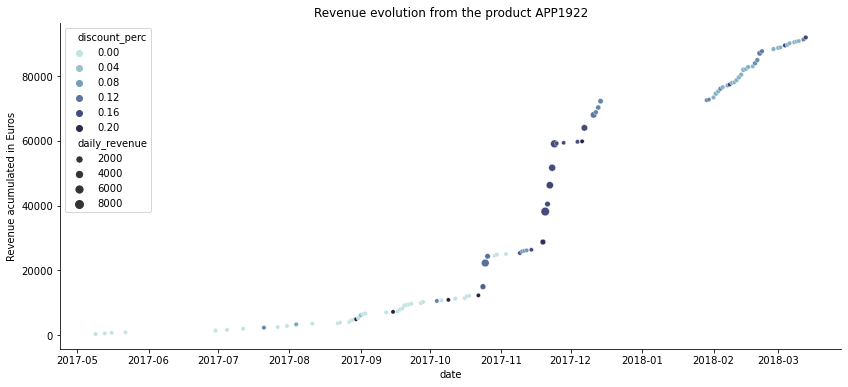

In [109]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.scatterplot(data=plot_data, x='date', y='cumsum_revenue', hue='discount_perc', 
                size='daily_revenue', palette="ch:start=.2,rot=-.3")
plt.title('Revenue evolution from the product ' + prod)
plt.ylabel('Revenue acumulated in Euros')
plt

sns.despine(left=False)

### Categories

In [202]:
accessory_exp = (r'(case|cable|adapter|[mM]ouse|support|keyboard|charger|dock|(Hard Drive)'+
                '|(SSD Disk)|AirPods|Headset|(Headphones)|[sS]peaker|(Hard Disk Thunderbolt)'+
                '|([Pp]encil)|[pP]en)|([Kk]eyboard)|[tT]rackpad|[mM]emory|(SSD Crucial MX300)' + 
                '(Apple Watch)|(Fitbit Smartwatch)|[mM]onitor')
# headphones_exp = r'(AirPods|Headset|(Headphones))'
tablet_exp = r"(Apple iPad)|([tT]ablet)"
# monitor_exp = r'([mM]onitor)'
smartphone_exp = r'(Apple iPhone)'
# smartwatch_exp = r'(Apple Watch)|(Fitbit Smartwatch)'
laptop_exp = r'((Apple MacBook Pro)|(Apple MacBook Air)|(Wacom MobileStudio Pro)|(Apple Macbook Air)|(Apple Macbook Pro 15))'
warranty_exp = r'(AppleCare Protection)'
software = r''
pc_exp = r'(Apple iMac)|(iMac Pro)|(Mac mini)'
nas_exp = r'NAS'


pd.set_option('display.max_rows', 1000)
# prod_cat = 
(
prod_revenue
    .loc[:,['sku','name']] #,'desc','revenue'
    .assign(
        accessory = prod_revenue['name'].str.count(accessory_exp), 
#         headphone = prod_revenue['name'].str.count(headphones_exp),
#         monitor = prod_revenue['name'].str.count(monitor_exp),
        smartphone = prod_revenue['name'].str.count(smartphone_exp),
#         smartwatch = prod_revenue['name'].str.count(smartwatch_exp),
        laptop = prod_revenue['name'].str.count(laptop_exp), 
        warranty = prod_revenue['name'].str.count(warranty_exp),
        pc = prod_revenue['name'].str.count(pc_exp), 
        tablet = prod_revenue['name'].str.count(tablet_exp), 
        nas = prod_revenue['name'].str.count(nas_exp),
        count = lambda x: x['accessory'] + x['smartphone'] + x['laptop'] + x['warranty'] + x['pc'] + x['tablet'] + x['nas']
    )
    .query(
# #         'accessory == 0 & monitor == 0 & smartphone == 0 & smartwatch == 0 & laptop == 0 & warranty == 0 & pc == 0 & tablet == 0 & nas == 0'
#         'accessory != 0 & monitor != 0 & smartphone != 0 & smartwatch != 0 & laptop != 0 & warranty != 0 & pc != 0 & tablet != 0 & nas != 0'
        'count > 1'
    )
)


,sku,name,accessory,smartphone,laptop,warranty,pc,tablet,nas,count
855,APP1922,AirPods Apple Bluetooth Headset for iPhone iPa...,2,0,0,0,0,0,0,2
2895,LGE0067,"43UD79-B LG Monitor 425 ""4K 72% NTSC USB-C Spe...",2,0,0,0,0,0,0,2
5696,WAC0171,Education - Wacom Intuos graphics tablet with ...,1,0,0,0,0,1,0,2
4965,SEA0105,IronWolf Seagate Hard Drive 8TB SATA NAS 3,1,0,0,0,0,0,1,2
4963,SEA0104,IronWolf Seagate Hard Drive 6TB SATA NAS 3,1,0,0,0,0,0,1,2
1027,APP2161,Smart Apple iPad Keyboard Case Keyboard Pro 10...,2,0,0,0,0,1,0,3
557,APP1215,Spanish Keyboard Keyboard Magic Apple Mac,2,0,0,0,0,0,0,2
4972,SEA0110,Seagate Hard Drive 4TB NAS IronWolf SATA 3,1,0,0,0,0,0,1,2
2865,LGE0041-A,"Open - LG 38UC99-W Monitor 38 ""UHD 4K USB 3.0 ...",2,0,0,0,0,0,0,2
2860,LGE0038-A,"Open - LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 ...",2,0,0,0,0,0,0,2


In [ ]:
prod_cat['category'] = prod['count']

In [ ]:
products = products.assign(new_type = ((products['type']).astype(float)%10000).astype(int))
#products.loc[products['sku'].str.contains("REP|SEV") & products['new_type'] == 0, 'type'] = 2062  #Services
#products.loc[products['sku'].str.contains("MOP|MOB") & products['new_type'] == 0, 'type'] = 230   #Acessory